In [54]:
import time

from dateutil.parser import parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.graph_objects as go

from ftx import FtxClient
from tqdm import tqdm

In [77]:
ftx = FtxClient()

# Filter futures with enough liquidity

In [78]:
df_futures = pd.DataFrame(columns=["future", "volumeUsd24h", "openInterestUsd"])

futures = ftx.get_futures()

idx = 0
for future in futures:
    if future["perpetual"] and future["volumeUsd24h"] > 1e6 and future["name"] != "USDT-PERP" and future["name"] != "UST-PERP":
        df_futures.loc[idx] = [future["name"], future["volumeUsd24h"], future["openInterestUsd"]]
        idx += 1

In [79]:
df_futures.sort_values("openInterestUsd")

,future,volumeUsd24h,openInterestUsd
92,PROM-PERP,1.074038e+06,1.778556e+05
103,SC-PERP,1.045461e+06,4.917759e+05
80,MTL-PERP,2.164782e+06,5.931944e+05
119,TOMO-PERP,1.515881e+06,6.694250e+05
61,IMX-PERP,2.100981e+06,7.437684e+05
...,...,...,...
130,XRP-PERP,1.728145e+08,9.932616e+07
73,LUNA-PERP,1.220422e+08,1.212536e+08
110,SOL-PERP,4.208882e+08,2.768876e+08
46,ETH-PERP,2.072676e+09,1.075170e+09


# Get future market data

In [81]:
markets = df_futures["future"].tolist()
resolution = 300 # in seconds (15, 60, 300, 900, 3600, 14400, 86400)
limit = 100 # number of points

In [82]:
df = pd.DataFrame()

pbar = tqdm(markets)
for market in pbar:
    try:
        pbar.set_description(market)
        data = ftx.get_historical_data(market, resolution=resolution, limit=limit)

        closing_price = np.zeros(len(data))
        times = []

        for idx, ele in enumerate(data):
            closing_price[idx] = float(ele["close"])
            times.append(parse(ele["startTime"]))

        df[market] = closing_price
        df["time"] = times
    except ValueError as exc:
        pass

df = df.set_index("time")
markets = df.columns.to_list()

RUNE-PERP:  74%|████████████████████████████████████████████████████████████████████████████▍                          | 101/136 [00:45<00:17,  1.95it/s]/var/folders/lv/5l60cz4j7mg_xthlrzqvyt8m0000gn/T/ipykernel_52667/3943674939.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

ZRX-PERP: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:01<00:00,  2.20it/s]


In [ ]:
df

# Analyze future data

In [15]:
def normalize_minmax(data: pd.Series):
    return (data - data.min()) / (data.max() - data.min())

def normalize_mean(data: pd.Series):
    return (data - data.mean()) / data.std()

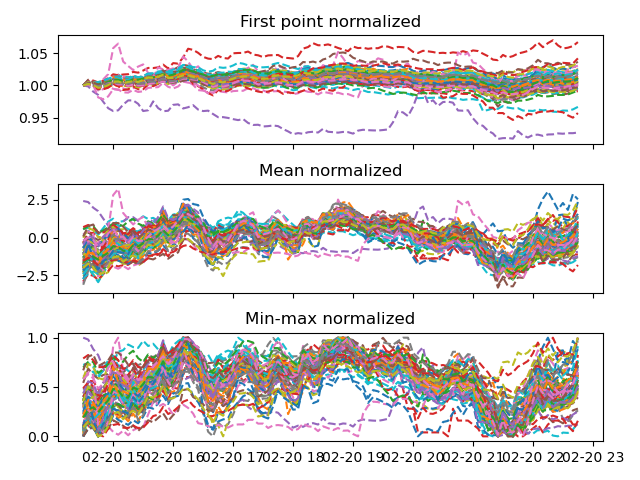

In [46]:
%matplotlib widget

fig, (ax, ax1, ax2) = plt.subplots(nrows=3, sharex=True)

for market in markets:
    ax.plot(df.index, df[market] / df[market][0] , "--", label=market)
    ax1.plot(df.index, normalize_mean(df[market]) , "--", label=market)
    ax2.plot(df.index, normalize_minmax(df[market]) , "--", label=market)
    
ax.set_title("First point normalized")
ax1.set_title("Mean normalized")
ax2.set_title("Min-max normalized")
fig.tight_layout()
# ax.legend()

# Overall correlation with Bitcoin

In [84]:
correlate_with = "BTC-PERP"
normalization_func = normalize_mean

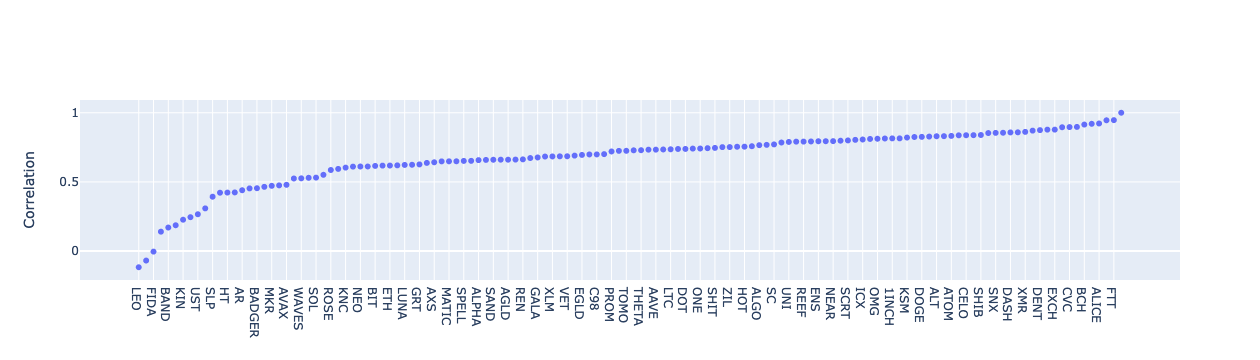

In [85]:
df_corr = pd.DataFrame(columns=["market", "correlation"])

for idx, market in enumerate(markets):
    df_corr.loc[idx] = [market.split("-")[0], np.corrcoef(normalization_func(df[correlate_with]), normalization_func(df[market]))[0][1]]
    
df_corr = df_corr.sort_values("correlation")

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_corr.market, y=df_corr.correlation,
                    mode='markers',
                    name='markers'))
fig.update_layout(
    yaxis_title="Correlation"
)

fig.show()

# Correlation with Bitcoin

In [96]:
correlate_with = "BTC-PERP"
normalization_func = normalize_mean

FIDA-PERP 34
LEO-PERP 94
MAPS-PERP -10
MINA-PERP 70
PAXG-PERP 67
PERP-PERP 95


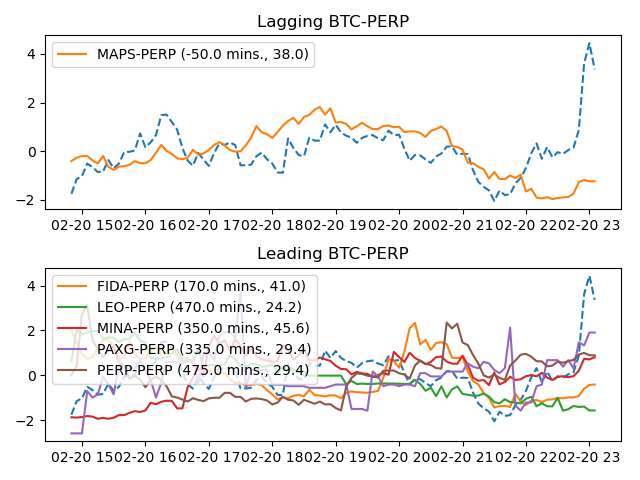

In [97]:
fig, (ax, ax1) = plt.subplots(nrows=2)

ax.plot(df.index, normalization_func(df[correlate_with]), "--")
ax1.plot(df.index, normalization_func(df[correlate_with]), "--")

for market in markets:
    corr = np.correlate(normalization_func(df[correlate_with]), normalization_func(df[market]), mode='full')
    lag = corr.argmax() - (len(df[market]) - 1)

    if abs(lag) > 5:
        lag_to_mins = lag * resolution / 60
        print(market, lag)

        if lag > 5:
            ax1.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins., {corr.max():.1f})")
        elif lag < -5:
            ax.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins., {corr.max():.1f})")

ax1.set_title(f"Leading {correlate_with}")
ax.set_title(f"Lagging {correlate_with}")

ax1.legend()
ax.legend()

fig.tight_layout()
#ax.legend()

# Correlation with Ethereum

In [88]:
correlate_with = "ETH-PERP"
normalization_func = normalize_mean

AXS-PERP 80
BSV-PERP 79
FIDA-PERP 37
GRT-PERP -80
HT-PERP 8
KNC-PERP 79
LEO-PERP 9
LTC-PERP 54
MAPS-PERP -8
MINA-PERP 74
ONT-PERP 80
PAXG-PERP 23
PERP-PERP 44
SOL-PERP 76
UST-PERP 56
WAVES-PERP 76
XAUT-PERP 40
YFI-PERP 76
ZEC-PERP 79
ZRX-PERP 79


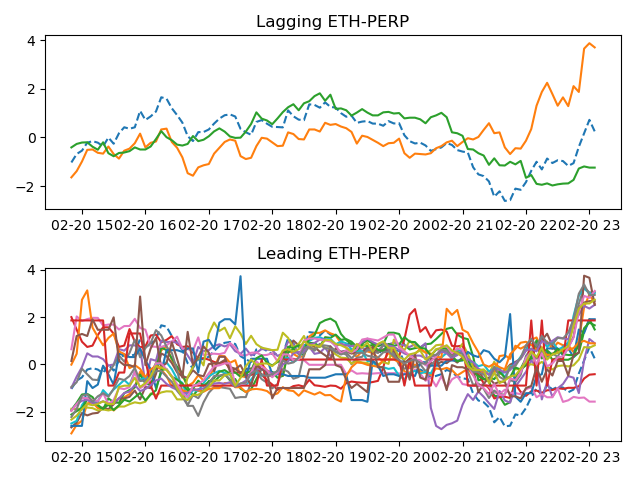

In [94]:
fig, (ax, ax1) = plt.subplots(nrows=2)

ax.plot(df.index, normalization_func(df[correlate_with]), "--")
ax1.plot(df.index, normalization_func(df[correlate_with]), "--")

for market in markets:
    corr = np.correlate(normalization_func(df[correlate_with]), normalization_func(df[market]), mode='full')
    lag = corr.argmax() - (len(df[market]) - 1)

    if abs(lag) > 5:
        lag_to_mins = lag * resolution / 60
        print(market, lag)

        if lag > 5:
            ax1.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins., {corr.max():.1f})")
        elif lag < -5:
            ax.plot(df.index, normalization_func(df[market]), "-", label=f"{market} ({lag_to_mins} mins.), {corr.max():.1f}")

ax1.set_title(f"Leading {correlate_with}")
ax.set_title(f"Lagging {correlate_with}")

#ax1.legend()
#ax.legend()

fig.tight_layout()
#ax.legend()

In [122]:
cols = ["c", "d", "e"]

df2 = pd.DataFrame(columns=["a", "b"] + cols)
df2

,a,b,c,d,e
